# Does proximity to amenities impacts the rental price for a property in Aberdeen?

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
1. [A description of the problem and a discussion of the background](#0)<br>
2. [Data sources](#1)<br>
3. [Data scraping and handling null values](#2)<br>
4. [Data Analysis](#3)<br>
5. [Downloading and analysing the FourSquare data against rental properties](#4)<br>
6. [Conclusion](#5)<br>

</div>

## A description of the problem and a discussion of the background.<a id="0"></a>

**Introduction/ Business Problem**

I have been renting in Aberdeen, Scotland for nearly 9 years and one thing I could never fully comprehend was the rental price. I would find 2 properties in close proximity to each other, and which to me seemed to be fairly similar, but with very different asking prices - £200 per month difference.

It got me thinking: 'What actually determines the rental price for a property in Aberdeen?'. Is it the location? Maybe the square footage or EPC band? What about it's proximity to amenities such as shops, cafes and restaurants? There is surprisingly less data publicly available on this matter than compared to that accessible to home buyers.

As part of the IBM Data Science Professional Certificate, this project required the use of FourSquare data. The analysis therefore looks at the relationship between the rental prices of properties in Aberdeen and their proximity to amenities clusters.

**Target audience**

The conclusions of this mini-research are meant to give my fellow renters some insight into rental prices in Aberdeen and what most impacts them. This in turn is meant to aid them into deciding on what to focus in their searches.

## Data sources<a id="1"></a>

The below data sources used for analysis have also been made available on my Github repository:
https://github.com/alex-spencer03/Coursera_Capstone.

1.	Data of rental properties available for rent: This was scraped from the Aberdeen Solicitors Property Centre’s (ASPC) website on the 15th July 2020: https://www.aspc.co.uk/.
2. Venue data from FourSquare's API

A full explanation of each dataset and features can be found in the final report available via the above GitHub link.

## Data scraping and handling null values<a id="2"></a>

In [2]:
# Importing required libraries

import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import json
import io
import requests	 # library to handle requests
import re  #very useful for defining search patterns

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


from sklearn.cluster import KMeans

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [5]:
# scrapping ASPC's website
url = 'https://www.aspc.co.uk/search/?PrimaryPropertyType=Rent&SortBy=PublishedDesc&LastUpdated=AddedAnytime&SearchTerm=&PropertyType=Residential&PriceMin=&PriceMax=&Bathrooms=&OrMoreBathrooms=true&Bedrooms=&OrMoreBedrooms=true&HasCentralHeating=false&HasGarage=false&HasDoubleGarage=false&HasGarden=false&IsNewBuild=false&IsDevelopment=false&IsParkingAvailable=false&IsPartExchangeConsidered=false&PublicRooms=&OrMorePublicRooms=true&IsHmoLicense=false&IsAllowPets=false&IsAllowSmoking=false&IsFullyFurnished=false&IsPartFurnished=false&IsUnfurnished=false&ExcludeUnderOffer=false&IncludeClosedProperties=true&ClosedDatesSearch=14&MapSearchType=EDITED&ResultView=LIST&ResultMode=NONE&AreaZoom=13&AreaCenter[lat]=57.14955426557916&AreaCenter[lng]=-2.0927401123046785&EditedZoom=13&EditedCenter[lat]=57.14955426557916&EditedCenter[lng]=-2.0927401123046785'
api_url = 'https://api.aspc.co.uk/Property/GetProperties?{}&Sort=PublishedDesc&Page=1&PageSize=639'

params = url.split('?')[-1]
data = requests.get(api_url.format(params)).json()

#print(json.dumps(data, indent=4))

In [6]:
# creating the initial pandas dataframe
column_names=['First_line','Second_line','City','Postcode','Bedrooms','Bathrooms','Lounges','Price','Square_ft','Property_type','Description','Coordinates']
properties = pd.DataFrame(columns=column_names)
properties

,First_line,Second_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Description,Coordinates


In [7]:
# pulling the required info for each column
for property_ in data:
    first_line=property_['Location']['AddressLine1']
    second_line=property_['Location']['LineTwoLocation']
    city=property_['Location']['City']
    postcode=property_['Location']['Postcode']
    bedrooms=property_['Bedrooms']
    bathrooms=property_['Bathrooms']
    lounges=property_['PublicRooms']
    price=property_['Price']
    square_ft=property_['FloorArea']
    property_type=property_['PropertyIconKey']
    description=property_['CategorisationDescription']
    coordinates=property_['Location']['Spatial']['Geography']['WellKnownText']
    
# amending the existing dataframe with required info
    properties=properties.append({'First_line': first_line,
                                 'Second_line':second_line,
                                 'City': city,
                                 'Postcode': postcode,
                                 'Bedrooms': bedrooms,
                                 'Bathrooms': bathrooms,
                                 'Lounges': lounges,
                                 'Price': price,
                                 'Square_ft': square_ft,
                                 'Property_type': property_type,
                                 'Description': description,
                                 'Coordinates': coordinates}, ignore_index=True)

properties.head()

,First_line,Second_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Description,Coordinates
0,63 Buckie Road,"Bridge Of Don, Aberdeen, AB22 8DN",Aberdeen,AB22 8DN,3,2,2,895.0,113.0,HOUSE_DETACHED,Fully furnished 3 Bdrm Detached Dwellhouse. Gr...,POINT (-2.12558450000006 57.1865374)
1,83 Menzies Road,"Aberdeen, AB11 9AQ",Aberdeen,AB11 9AQ,1,1,1,350.0,38.0,FLAT,Fully furnished 1 Bdrm Top flr Flat. Hall. Lou...,POINT (-2.09286050000003 57.1354396)
2,22 Bridge Street,"Aberdeen, AB11 6JJ",Aberdeen,AB11 6JJ,2,1,1,500.0,0.0,FLAT,Part furnished 2 Bdrm Top flr Flat. Hall. Loun...,POINT (-2.1016768 57.144914)
3,15d Mackie Place,"Elrick, Westhill, AB32 6AN",Westhill,AB32 6AN,3,2,1,700.0,82.0,FLAT,Fully furnished 3 Bdrm 1st flr Flat. Hall. Lou...,POINT (-2.3112582 57.1483998)
4,28 Barratt Drive,"Ellon, AB41 9RX",Ellon,AB41 9RX,2,1,1,575.0,60.0,FLAT,Unfurnished 2 Bdrm Upper Self-contained flat. ...,POINT (-2.0847617 57.3607013)


In [8]:
properties.shape

(498, 12)

### Data cleaning and handling null values

In [9]:
# creating the Council tax, EPC band, Garden and Parking columns by extracting the data from the Description column
# note to self: (?i) case insensitive modifier

properties['Council_tax_band'] = properties['Description'].str.extract(r'(?i)\(((?:CT)[^()*&?%]+)\)', expand=False)
properties['EPC_band'] = properties['Description'].str.extract(r'(?i)\(((?:EPC)[^()*&?%]+)\)', expand=False)
properties['Garden']= properties.Description.str.extract(r'\b(Garden)\b', expand=False)
properties['Parking']= properties.Description.str.extract(r'\b(Parking)\b', expand=False)

#sorting out the latitude and longitude of the properties
properties['Coordinates']=properties.Coordinates.str.strip('POINT (')
properties['Coordinates']=properties.Coordinates.str.strip(')')
properties['Longitude'], properties['Latitude']= properties['Coordinates'].str.split(' ',1).str

#dropping columns no longer required
properties.drop(['Description'], axis=1, inplace=True)
properties.drop(['Second_line'], axis=1, inplace=True)
properties.drop(['Coordinates'], axis=1, inplace=True)

properties.head()

<ipython-input-9-ad911957dbd6>:12: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  properties['Longitude'], properties['Latitude']= properties['Coordinates'].str.split(' ',1).str


,First_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Garden,Parking,Longitude,Latitude
0,63 Buckie Road,Aberdeen,AB22 8DN,3,2,2,895.0,113.0,HOUSE_DETACHED,CT band - F,EPC band - C,Garden,Parking,-2.12558450000006,57.1865374
1,83 Menzies Road,Aberdeen,AB11 9AQ,1,1,1,350.0,38.0,FLAT,CT band - A,EPC band - C,Garden,Parking,-2.09286050000003,57.1354396
2,22 Bridge Street,Aberdeen,AB11 6JJ,2,1,1,500.0,0.0,FLAT,CT band - C,EPC band - G,NaN,NaN,-2.1016768,57.144914
3,15d Mackie Place,Westhill,AB32 6AN,3,2,1,700.0,82.0,FLAT,CT band - C,EPC band - B,NaN,Parking,-2.3112582,57.1483998
4,28 Barratt Drive,Ellon,AB41 9RX,2,1,1,575.0,60.0,FLAT,CT band - TBC,EPC band - C,Garden,Parking,-2.0847617,57.3607013


In [10]:
# checking Council Tax bands are pulled across correctly
properties['Council_tax_band'].value_counts()

CT band - A      68
CT band - B      54
CT band - D      50
CT band - C      50
CT Band - D      43
CT band - TBC    39
CT Band - A      34
CT Band - B      31
CT Band - C      27
CT band - E      23
CT Band - E      17
CT Band - TBC    16
CT band - F      15
CT band - G       6
CT Band - G       5
CT Band - F       4
CT Band - H       2
CT band - H       2
CT band - C       1
CT band -F        1
CT band -TBC      1
CT band B         1
CT band -E        1
CT band A         1
CT band -B        1
CT - Band D       1
Ct band - D       1
Name: Council_tax_band, dtype: int64

### Because the `Council_tax_band` strings pulled from ASPC's API are not consistent further work is required on them.

In [11]:
#striping down council tax data
properties['Council_tax_band']=properties.Council_tax_band.str.rstrip()
properties['Council_tax_band']=properties.Council_tax_band.str.replace('band', 'Band')
properties['Council_tax_band']=properties.Council_tax_band.str.replace('CT - Band TBC','CT Band - TBC')
properties['Council_tax_band']=properties.Council_tax_band.str.replace('CT BandTBC','CT Band - TBC')
properties['Council_tax_band']=properties.Council_tax_band.str.replace('CT Band -E','CT Band - E')
properties['Council_tax_band']=properties.Council_tax_band.str.replace('CT Band -F','CT Band - F')
properties['Council_tax_band']=properties.Council_tax_band.str.replace(' -','')

properties['EPC_band']=properties.EPC_band.str.replace(' -','')

#making property_type entries more pleasent to view
properties['Property_type']=properties.Property_type.str.replace('FLAT', 'Flat')
properties['Property_type']=properties.Property_type.str.replace('HOUSE_SEMI_DETACHED', 'House Semi Detached')
properties['Property_type']=properties.Property_type.str.replace('HOUSE_DETACHED', 'House Detached')
properties['Property_type']=properties.Property_type.str.replace('HOUSE_TERRACED', 'House Terraced')

properties.head()

,First_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Garden,Parking,Longitude,Latitude
0,63 Buckie Road,Aberdeen,AB22 8DN,3,2,2,895.0,113.0,House Detached,CT Band F,EPC band C,Garden,Parking,-2.12558450000006,57.1865374
1,83 Menzies Road,Aberdeen,AB11 9AQ,1,1,1,350.0,38.0,Flat,CT Band A,EPC band C,Garden,Parking,-2.09286050000003,57.1354396
2,22 Bridge Street,Aberdeen,AB11 6JJ,2,1,1,500.0,0.0,Flat,CT Band C,EPC band G,NaN,NaN,-2.1016768,57.144914
3,15d Mackie Place,Westhill,AB32 6AN,3,2,1,700.0,82.0,Flat,CT Band C,EPC band B,NaN,Parking,-2.3112582,57.1483998
4,28 Barratt Drive,Ellon,AB41 9RX,2,1,1,575.0,60.0,Flat,CT Band TBC,EPC band C,Garden,Parking,-2.0847617,57.3607013


In [12]:
#sanity check
properties['Council_tax_band'].value_counts()

CT Band A      103
CT Band D       94
CT Band B       86
CT Band C       78
CT Band TBC     55
CT Band E       41
CT Band F       20
CT Band G       11
CT Band H        4
CT BandTBC       1
Ct Band D        1
CT BandB         1
Name: Council_tax_band, dtype: int64

#### Much better

In [14]:
# creating dataframe containing only rental properties in Aberdeen
aberdeen_master=properties[properties['City'] == 'Aberdeen'].reset_index(drop=True)
aberdeen_master.head()

,First_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Garden,Parking,Longitude,Latitude
0,63 Buckie Road,Aberdeen,AB22 8DN,3,2,2,895.0,113.0,House Detached,CT Band F,EPC band C,Garden,Parking,-2.12558450000006,57.1865374
1,83 Menzies Road,Aberdeen,AB11 9AQ,1,1,1,350.0,38.0,Flat,CT Band A,EPC band C,Garden,Parking,-2.09286050000003,57.1354396
2,22 Bridge Street,Aberdeen,AB11 6JJ,2,1,1,500.0,0.0,Flat,CT Band C,EPC band G,NaN,NaN,-2.1016768,57.144914
3,71 Strawberry Bank Parade,Aberdeen,AB11 6UT,2,1,1,550.0,55.0,Flat,CT Band D,EPC band B,Garden,Parking,-2.1088639,57.1415038
4,138F King Street,Aberdeen,AB24 5BD,2,1,1,495.0,52.0,Flat,CT Band A,EPC band D,NaN,NaN,-2.0938387,57.1510059


In [15]:
aberdeen_master.shape

(391, 15)

### Now that we have a set dataframe we need to investigate and handle any null values which will impact the analysis

In [16]:
#checking the entire dataframe for null values
aberdeen_master.isnull().sum()

First_line            0
City                  0
Postcode              0
Bedrooms              0
Bathrooms             0
Lounges               0
Price                 0
Square_ft             0
Property_type         0
Council_tax_band      3
EPC_band              0
Garden              258
Parking             172
Longitude             0
Latitude              0
dtype: int64

In [17]:
#checking which properties do not have a council tax entry
aberdeen_master[aberdeen_master['Council_tax_band'].isnull()]

,First_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Garden,Parking,Longitude,Latitude
221,"Flat A, 29 Walker Road",Aberdeen,AB11 8DP,1,1,1,375.0,0.0,Flat,NaN,EPC band C,Garden,NaN,-2.08931800000005,57.1363565
229,125 Spring Garden,Aberdeen,AB25 1DG,1,1,1,400.0,0.0,Flat,NaN,EPC band C,NaN,Parking,-2.10179429999994,57.1527173
310,"Flat B, 38 Rose Street",Aberdeen,AB10 1UD,2,1,1,500.0,0.0,Flat,NaN,EPC band D,NaN,NaN,-2.11166270740967,57.1443011521126


In [18]:
#checking which properties do not have an EPC entry
aberdeen_master[aberdeen_master['EPC_band'].isnull()]

,First_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Garden,Parking,Longitude,Latitude


In [19]:
#checking properties with no Square_ft data
aberdeen_master.loc[aberdeen_master['Square_ft'] == 0]

,First_line,City,Postcode,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Garden,Parking,Longitude,Latitude
2,22 Bridge Street,Aberdeen,AB11 6JJ,2,1,1,500.0,0.0,Flat,CT Band C,EPC band G,NaN,NaN,-2.1016768,57.144914
5,"Flat F, 51 Marischal Street",Aberdeen,AB11 5AB,1,1,1,390.0,0.0,Flat,CT Band TBC,EPC band C,NaN,NaN,-2.09187506931152,57.1467706811046
12,53 Stockethill Crescent,Aberdeen,AB16 5TT,1,1,1,395.0,0.0,Flat,CT Band A,EPC band C,NaN,Parking,-2.14537919999998,57.1564108
16,14 Watson Street,Aberdeen,AB25 2QD,1,1,1,450.0,0.0,Flat,CT Band C,EPC band E,NaN,NaN,-2.1176865,57.1504003
19,"GFL, 33 Ashvale Place",Aberdeen,AB10 6QD,1,1,1,395.0,0.0,Flat,CT Band TBC,EPC band F,Garden,NaN,-2.1154094,57.1407372
23,"140 Dee Village, Millburn Street",Aberdeen,AB11 6SY,3,2,1,1000.0,0.0,Flat,CT Band E,EPC band C,NaN,Parking,-2.09905209999999,57.1388515
25,"Flat A, 12 Seaton Avenue",Aberdeen,AB24 1XB,2,1,1,325.0,0.0,Flat,CT Band B,EPC band E,NaN,NaN,-2.09346059999996,57.1678847
26,"Flat 1, 46 Gilcomston Park",Aberdeen,AB25 1PL,1,1,1,435.0,0.0,Flat,CT Band TBC,EPC band E,NaN,NaN,-2.10928947422238,57.1489237613353
27,"Flat 31, 44 Gilcomston Park",Aberdeen,AB25 1PL,1,1,2,485.0,0.0,Flat,CT Band TBC,EPC band F,NaN,NaN,-2.10901773862304,57.1490922389754
28,48 Deeside Gardens,Aberdeen,AB15 7PN,4,1,4,1300.0,0.0,House Detached,CT Band F,EPC band D,Garden,Parking,-2.145494,57.125404


In [21]:
# given the high number of 0 entries for Square_ft, checking the correlation between it and Price
prop_sqft=pd.DataFrame((aberdeen_master.loc[aberdeen_master['Square_ft'] > 0])).reset_index(drop=True)
prop_sqft[['Price','Square_ft']].corr()

,Price,Square_ft
Price,1.00000,0.86518
Square_ft,0.86518,1.00000


(0.0, 2610.376976755691)

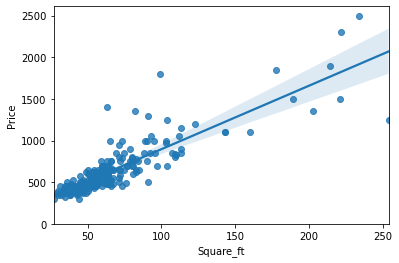

In [22]:
# plotting it
sns.regplot(x="Square_ft", y="Price", data=prop_sqft)
plt.ylim(0,)

### Important: this data was initially pulled on 15th July 2020 and the above code was for illustrative purposes only.

Just as can be seen now the number of properties without square footage values is high. To obtain this data would have been very time consuming and I had to deternine if it had any value to bring to justify the time and resources to obtain it.

As can be seen in the above .corr() function there is a 0.851765 correlation between the price and the square footage of the property. The above scatter plot confirms this. Not including this data could have skewed the final results.

The initial properties dataset was persisted to DB2 Warehouse on 15th July 2020 and uploaded to GitHub on 5th August 2020.

## Data Analysis<a id="3"></a>

In [23]:
# Downloading csv file from my GitHub account
url2 = "https://raw.githubusercontent.com/alex-spencer03/Coursera_Capstone/master/aberdeen_master.csv"
download = requests.get(url2).content

# Reading downloaded content into pandas dataframe
aberdeen_master = pd.read_csv(io.StringIO(download.decode('utf-8')))

# sanity check
aberdeen_master.head()

,First_line,City,Postcode,Council_ward,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Property_type,Council_tax_band,EPC_band,Parking,Longitude,Latitude
0,2 Albert Den,Aberdeen,AB25 1YX,Midstocket/Rosemount,2,2,1,750,75,Flat,CT Band E,EPC band C,Parking,-2.117279,57.146122
1,3c Anderson Drive,Aberdeen,AB15 4ST,Airyhall/Broomhill/Garthdee,2,2,1,750,82,Flat,CT Band E,EPC band C,Parking,-2.134406,57.133631
2,11 Cypress Avenue,Aberdeen,AB23 8LA,Bridge of Don,2,1,1,625,69,House Semi Detached,CT Band C,EPC band C,Parking,-2.100588,57.199485
3,"First Floor Left, 31 Bank Street",Aberdeen,AB11 7TA,Torry/Ferryhill,1,1,1,475,46,Flat,CT Band B,EPC band C,Parking,-2.100533,57.138016
4,66 Ashgrove Road,Aberdeen,AB25 3AD,Midstocket/Rosemount,2,1,1,550,53,Flat,CT Band B,EPC band D,NaN,-2.119067,57.158794


In [24]:
#sanity check
print(aberdeen_master.dtypes)

First_line           object
City                 object
Postcode             object
Council_ward         object
Bedrooms              int64
Bathrooms             int64
Lounges               int64
Price                 int64
Square_ft             int64
Property_type        object
Council_tax_band     object
EPC_band             object
Parking              object
Longitude           float64
Latitude            float64
dtype: object


In [25]:
# Dropping City attribute as all instances have the same city
aberdeen_master.drop(['City'], axis=1, inplace=True)

# checking dataset
aberdeen_master.describe()

,Bedrooms,Bathrooms,Lounges,Price,Square_ft,Longitude,Latitude
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,1.894619,1.215247,1.065022,639.094170,65.964126,-2.117851,57.151481
std,0.834707,0.443014,0.325384,268.684001,32.615962,0.027320,0.016319
min,1.000000,1.000000,0.000000,325.000000,26.000000,-2.263654,57.096120
25%,1.000000,1.000000,1.000000,475.000000,47.000000,-2.126179,57.140279
50%,2.000000,1.000000,1.000000,550.000000,58.000000,-2.112189,57.148793
75%,2.000000,1.000000,1.000000,700.000000,75.000000,-2.100270,57.158662
max,6.000000,3.000000,4.000000,2300.000000,330.000000,-2.078191,57.212590


#### Let's calculate and then visualise the correlation between the numerical variables

In [26]:
aberdeen_master[['Price','Bedrooms','Bathrooms','Lounges','Square_ft','Parking']].corr()

,Price,Bedrooms,Bathrooms,Lounges,Square_ft
Price,1.000000,0.791809,0.647835,0.530821,0.785406
Bedrooms,0.791809,1.000000,0.511176,0.480349,0.728791
Bathrooms,0.647835,0.511176,1.000000,0.308011,0.601473
Lounges,0.530821,0.480349,0.308011,1.000000,0.616610
Square_ft,0.785406,0.728791,0.601473,0.616610,1.000000


(0.0, 2398.75)

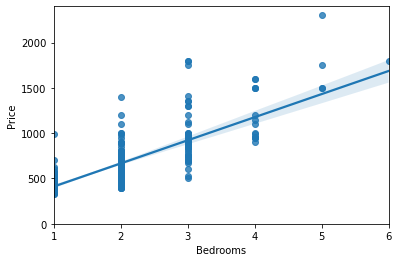

In [27]:
sns.regplot(x='Bedrooms', y='Price', data=aberdeen_master)
plt.ylim(0,)

(0.0, 2398.75)

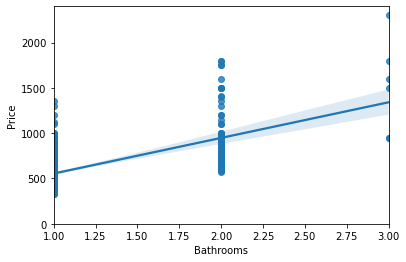

In [28]:
sns.regplot(x='Bathrooms', y='Price', data=aberdeen_master)
plt.ylim(0,)

(0.0, 2412.728723549084)

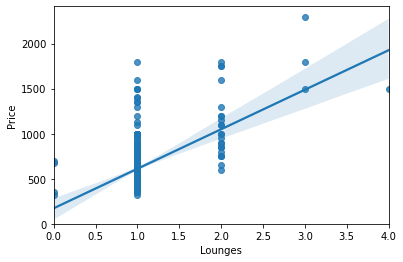

In [29]:
sns.regplot(x='Lounges', y='Price', data=aberdeen_master)
plt.ylim(0,)

(0.0, 2884.119036961632)

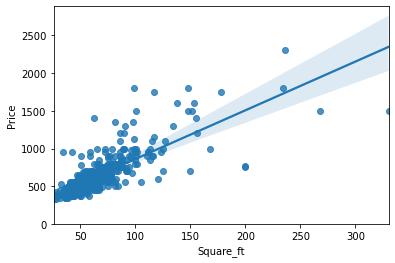

In [30]:
sns.regplot(x='Square_ft', y='Price', data=aberdeen_master)
plt.ylim(0,)

#### Calculating and visualising the correlation between the categorical variables

[Text(0, 0, 'CT Band E'),
 Text(1, 0, 'CT Band C'),
 Text(2, 0, 'CT Band B'),
 Text(3, 0, 'CT Band F'),
 Text(4, 0, 'CT Band D'),
 Text(5, 0, 'CT Band A'),
 Text(6, 0, 'CT Band H'),
 Text(7, 0, 'CT Band G')]

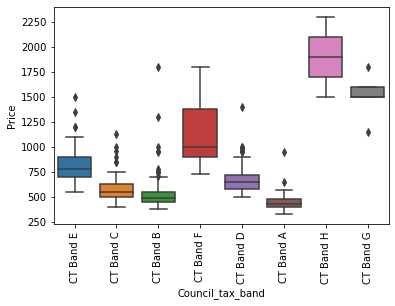

In [31]:
ax=sns.boxplot(x="Council_tax_band", y="Price", data=aberdeen_master)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

[Text(0, 0, 'EPC band C'),
 Text(1, 0, 'EPC band D'),
 Text(2, 0, 'EPC band B'),
 Text(3, 0, 'EPC band E'),
 Text(4, 0, 'EPC band F'),
 Text(5, 0, 'EPC band G')]

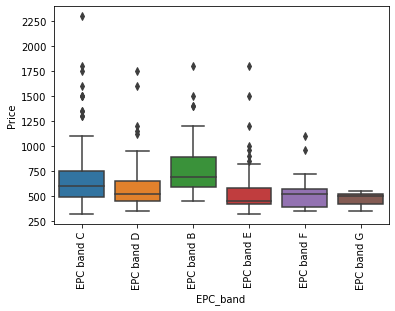

In [32]:
ax=sns.boxplot(x="EPC_band", y="Price", data=aberdeen_master)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

[Text(0, 0, 'Midstocket/Rosemount'),
 Text(1, 0, 'Airyhall/Broomhill/Garthdee'),
 Text(2, 0, 'Bridge of Don'),
 Text(3, 0, 'Torry/Ferryhill'),
 Text(4, 0, 'Lower Deeside'),
 Text(5, 0, 'Hazlehead/Queens Cross/Countesswells'),
 Text(6, 0, 'George St/Harbour'),
 Text(7, 0, 'Kingswells/Sheddocksley/Summerhill'),
 Text(8, 0, 'Dyce/Bucksburn/Danestone'),
 Text(9, 0, 'Tillydrone/Seaton/Old Aberdeen'),
 Text(10, 0, 'Hilton/Woodside/Stockethill'),
 Text(11, 0, 'Northfield/Mastrick North'),
 Text(12, 0, 'Kincorth/Nigg/Cove')]

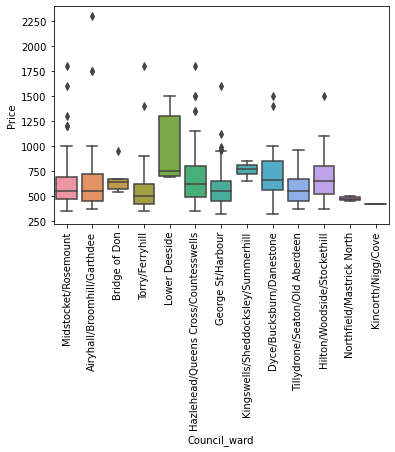

In [33]:
ax=sns.boxplot(x="Council_ward", y="Price", data=aberdeen_master)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [34]:
#applying one-hot encoding to the categorical variables for further analysis
for column in ['Property_type','Council_tax_band','EPC_band','Parking']:
    dummies = pd.get_dummies(aberdeen_master[column])
    aberdeen_master[dummies.columns] = dummies

In [35]:
# checking correlation between price and council tax bands
aberdeen_master[['Price','CT Band A', 'CT Band B', 'CT Band C', 'CT Band D', 'CT Band E', 'CT Band F', 'CT Band G', 'CT Band H']].corr()

,Price,CT Band A,CT Band B,CT Band C,CT Band D,CT Band E,CT Band F,CT Band G,CT Band H
Price,1.000000,-0.375616,-0.195710,-0.093564,0.078062,0.243886,0.450128,0.345527,0.315320
CT Band A,-0.375616,1.000000,-0.263328,-0.231483,-0.273790,-0.178663,-0.117244,-0.053538,-0.033746
CT Band B,-0.195710,-0.263328,1.000000,-0.241115,-0.285182,-0.186097,-0.122122,-0.055766,-0.035150
CT Band C,-0.093564,-0.231483,-0.241115,1.000000,-0.250694,-0.163592,-0.107354,-0.049022,-0.030899
CT Band D,0.078062,-0.273790,-0.285182,-0.250694,1.000000,-0.193490,-0.126974,-0.057981,-0.036546
CT Band E,0.243886,-0.178663,-0.186097,-0.163592,-0.193490,1.000000,-0.082857,-0.037836,-0.023848
CT Band F,0.450128,-0.117244,-0.122122,-0.107354,-0.126974,-0.082857,1.000000,-0.024829,-0.015650
CT Band G,0.345527,-0.053538,-0.055766,-0.049022,-0.057981,-0.037836,-0.024829,1.000000,-0.007146
CT Band H,0.315320,-0.033746,-0.035150,-0.030899,-0.036546,-0.023848,-0.015650,-0.007146,1.000000


In [36]:
# checking correlation between price and EPC bands
aberdeen_master[['Price','EPC band B','EPC band C','EPC band D','EPC band E','EPC band F','EPC band G']].corr()

,Price,EPC band B,EPC band C,EPC band D,EPC band E,EPC band F,EPC band G
Price,1.000000,0.173624,0.136696,-0.156957,-0.084807,-0.064120,-0.052870
EPC band B,0.173624,1.000000,-0.270411,-0.216743,-0.114030,-0.062483,-0.025830
EPC band C,0.136696,-0.270411,1.000000,-0.594887,-0.312976,-0.171495,-0.070895
EPC band D,-0.156957,-0.216743,-0.594887,1.000000,-0.250860,-0.137459,-0.056825
EPC band E,-0.084807,-0.114030,-0.312976,-0.250860,1.000000,-0.072318,-0.029896
EPC band F,-0.064120,-0.062483,-0.171495,-0.137459,-0.072318,1.000000,-0.016382
EPC band G,-0.052870,-0.025830,-0.070895,-0.056825,-0.029896,-0.016382,1.000000


#### Let's investigate a bit more the relationship between the different variables by looking at the average prices

In [39]:
# new dataframe
test_one=aberdeen_master[['Bedrooms','Bathrooms','Lounges','Square_ft','Price']]
ab_avg_price=test_one.groupby(['Bedrooms','Bathrooms','Lounges'], as_index=False).mean()
ab_avg_price['Sq_diff']=ab_avg_price['Square_ft'].diff()
ab_avg_price['Price_diff']=ab_avg_price['Price'].diff()

ab_avg_price

,Bedrooms,Bathrooms,Lounges,Square_ft,Price,Sq_diff,Price_diff
0,1,1,0,32.500000,337.500000,NaN,NaN
1,1,1,1,45.164384,454.547945,12.664384,117.047945
2,2,1,1,61.182353,581.788235,16.017969,127.240290
3,2,1,2,79.666667,681.666667,18.484314,99.878431
4,2,2,1,80.102041,765.163265,0.435374,83.496599
5,2,2,2,82.000000,895.000000,1.897959,129.836735
6,3,1,0,95.000000,687.500000,13.000000,-207.500000
7,3,1,1,79.000000,856.304348,-16.000000,168.804348
8,3,1,2,91.142857,878.571429,12.142857,22.267081
9,3,2,1,99.200000,955.000000,8.057143,76.428571


#### Now let's see what the average rental property looks like in each council ward

In [40]:
# new dataframe
test_one=aberdeen_master[['Council_ward','Bedrooms','Bathrooms','Lounges','Square_ft','Price']]
c_ward_avg=test_one.groupby(['Council_ward'], as_index=False).mean()
c_ward_avg.sort_values(by=['Price'], inplace=True, ascending=False)
c_ward_avg

,Council_ward,Bedrooms,Bathrooms,Lounges,Square_ft,Price
8,Lower Deeside,2.800000,1.600000,1.200000,107.000000,989.000000
7,Kingswells/Sheddocksley/Summerhill,2.750000,1.250000,1.500000,82.250000,762.500000
0,Airyhall/Broomhill/Garthdee,2.090909,1.272727,1.181818,71.954545,742.045455
2,Dyce/Bucksburn/Danestone,2.175000,1.350000,1.125000,86.450000,721.550000
4,Hazlehead/Queens Cross/Countesswells,1.924242,1.303030,1.121212,74.878788,708.181818
5,Hilton/Woodside/Stockethill,2.238095,1.285714,1.095238,72.904762,702.380952
1,Bridge of Don,2.000000,1.166667,1.166667,68.500000,665.000000
9,Midstocket/Rosemount,1.757576,1.257576,1.090909,62.575758,643.712121
11,Tillydrone/Seaton/Old Aberdeen,2.047619,1.047619,0.952381,63.238095,591.904762
3,George St/Harbour,1.831858,1.123894,1.000000,58.716814,577.292035


#### Let's cluster the properties and visualise the clusters

In [41]:
# setting the number of clusters - looks like the best choice. K algorithm could be performed
kclusters = 3

aberdeen_grouped_clustering = aberdeen_master[['Bedrooms','Bathrooms','Lounges','Square_ft','Price','Latitude','Longitude']]

# running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(aberdeen_grouped_clustering)

# adding clustering labels
aberdeen_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
aberdeen_grouped_clustering.head()

,Cluster Labels,Bedrooms,Bathrooms,Lounges,Square_ft,Price,Latitude,Longitude
0,2,2,2,1,75,750,57.146122,-2.117279
1,2,2,2,1,82,750,57.133631,-2.134406
2,0,2,1,1,69,625,57.199485,-2.100588
3,0,1,1,1,46,475,57.138016,-2.100533
4,0,2,1,1,53,550,57.158794,-2.119067


In [42]:
#adding the council_wards into dataframe
council_w=aberdeen_master[['Council_ward','Latitude']]
aberdeen_grouped_clustering=pd.merge(aberdeen_grouped_clustering, council_w, on='Latitude')

# move neighborhood column to the first column
cols = [aberdeen_grouped_clustering.columns[-1]] + list(aberdeen_grouped_clustering.columns[:-1])
aberdeen_grouped_clustering = aberdeen_grouped_clustering[cols]

aberdeen_grouped_clustering.head()

,Council_ward,Cluster Labels,Bedrooms,Bathrooms,Lounges,Square_ft,Price,Latitude,Longitude
0,Midstocket/Rosemount,2,2,2,1,75,750,57.146122,-2.117279
1,Airyhall/Broomhill/Garthdee,2,2,2,1,82,750,57.133631,-2.134406
2,Bridge of Don,0,2,1,1,69,625,57.199485,-2.100588
3,Torry/Ferryhill,0,1,1,1,46,475,57.138016,-2.100533
4,Midstocket/Rosemount,0,2,1,1,53,550,57.158794,-2.119067


In [43]:
#getting the coordinates for Aberdeen city
address = 'Aberdeen, Scotland'

geolocator = Nominatim(user_agent="ab_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Aberdeen, Scotland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Aberdeen, Scotland are 57.1482429, -2.0928095.


In [44]:
# creating the map of clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting the color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding the markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(aberdeen_grouped_clustering['Latitude'], aberdeen_grouped_clustering['Longitude'], aberdeen_grouped_clustering['Council_ward'], aberdeen_grouped_clustering['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Finally, let's examine each cluster

In [45]:
#Examining the first cluster of properties
cluster_one=pd.DataFrame(aberdeen_grouped_clustering.loc[aberdeen_grouped_clustering['Cluster Labels'] == 0])
cluster_one.describe()

,Cluster Labels,Bedrooms,Bathrooms,Lounges,Square_ft,Price,Latitude,Longitude
count,332.0,332.000000,332.000000,332.00000,332.000000,332.000000,332.000000,332.000000
mean,0.0,1.521084,1.030120,1.00000,52.448795,504.765060,57.151543,-2.113819
std,0.0,0.518108,0.171177,0.10993,13.372892,83.356144,0.015918,0.022576
min,0.0,1.000000,1.000000,0.00000,26.000000,325.000000,57.096701,-2.190493
25%,0.0,1.000000,1.000000,1.00000,43.000000,445.000000,57.140361,-2.119906
50%,0.0,2.000000,1.000000,1.00000,50.000000,500.000000,57.149014,-2.110062
75%,0.0,2.000000,1.000000,1.00000,60.000000,571.250000,57.157350,-2.099129
max,0.0,3.000000,2.000000,2.00000,121.000000,650.000000,57.212590,-2.078191


In [46]:
#Examining the second cluster of properties
cluster_two=pd.DataFrame(aberdeen_grouped_clustering.loc[aberdeen_grouped_clustering['Cluster Labels'] == 1])
cluster_two.describe()

,Cluster Labels,Bedrooms,Bathrooms,Lounges,Square_ft,Price,Latitude,Longitude
count,22.0,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,1.0,3.681818,2.045455,1.727273,148.045455,1527.500000,57.144258,-2.133763
std,0.0,1.041353,0.575473,0.882735,66.948080,262.985379,0.016144,0.025848
min,1.0,2.000000,1.000000,1.000000,63.000000,1200.000000,57.115645,-2.194117
25%,1.0,3.000000,2.000000,1.000000,98.250000,1350.000000,57.134654,-2.143769
50%,1.0,3.500000,2.000000,1.500000,143.000000,1500.000000,57.144239,-2.132712
75%,1.0,4.000000,2.000000,2.000000,155.750000,1712.500000,57.149096,-2.118246
max,1.0,6.000000,3.000000,4.000000,330.000000,2300.000000,57.184614,-2.086557


In [47]:
#Examining the third and final cluster of properties
cluster_three=pd.DataFrame(aberdeen_grouped_clustering.loc[aberdeen_grouped_clustering['Cluster Labels'] == 2])
cluster_three.describe()

,Cluster Labels,Bedrooms,Bathrooms,Lounges,Square_ft,Price,Latitude,Longitude
count,126.0,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,2.0,2.476190,1.547619,1.103175,88.095238,822.309524,57.155867,-2.129234
std,0.0,0.665904,0.530768,0.353935,29.248844,119.889714,0.019533,0.036663
min,2.0,1.000000,1.000000,0.000000,34.000000,675.000000,57.096120,-2.263654
25%,2.0,2.000000,1.000000,1.000000,72.000000,710.000000,57.142875,-2.138267
50%,2.0,2.000000,2.000000,1.000000,82.500000,795.000000,57.151138,-2.123748
75%,2.0,3.000000,2.000000,1.000000,96.750000,900.000000,57.165151,-2.102581
max,2.0,4.000000,3.000000,2.000000,200.000000,1150.000000,57.212590,-2.081247


## Downloading and analysing the FourSquare data against rental properties<a id="4"></a>

In [48]:
CLIENT_ID = 'EXSW1MIZO4ZE4VQQP3ZW0GN3KCNDP5ZEWYIC25EUOTMG5Y24' # Foursquare ID
CLIENT_SECRET = 'VTQFVGSCC0H5GWDIWSZK3RQRHICOF0JB2MHS4CA5ROTLQOTB' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EXSW1MIZO4ZE4VQQP3ZW0GN3KCNDP5ZEWYIC25EUOTMG5Y24
CLIENT_SECRET:VTQFVGSCC0H5GWDIWSZK3RQRHICOF0JB2MHS4CA5ROTLQOTB


In [49]:
LIMIT = 700 # limiting number of venues returned by Foursquare API
radius = 7000 # defining radius

# creating URL
url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

url3

'https://api.foursquare.com/v2/venues/explore?&client_id=EXSW1MIZO4ZE4VQQP3ZW0GN3KCNDP5ZEWYIC25EUOTMG5Y24&client_secret=VTQFVGSCC0H5GWDIWSZK3RQRHICOF0JB2MHS4CA5ROTLQOTB&v=20180605&ll=57.1482429,-2.0928095&radius=7000&limit=700'

In [50]:
# getting results
results = requests.get(url3).json()
results

{'meta': {'code': 200, 'requestId': '601af65fb20a7c3f0c73ab20'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Aberdeen',
  'headerFullLocation': 'Aberdeen',
  'headerLocationGranularity': 'city',
  'totalResults': 110,
  'suggestedBounds': {'ne': {'lat': 57.21124296300006,
    'lng': -1.9768901907487855},
   'sw': {'lat': 57.08524283699994, 'lng': -2.2087288092512147}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5669d04e498e6356a17d6440',
       'name': 'BrewDog Castlegate',
       'location': {'address': '5-9 Union St',
        'lat': 57.14773069623862,
        'lng': -2.094548465423609,
        'labeledLatLngs': [{'label': 'display',
          'lat': 57.14773069623862,
  

In [51]:
# getting results into a dataframe
venues = results['response']['groups'][0]['items']

ab_venues = pd.json_normalize(venues) # flattens JSON

# filtering the columns
filtered_columns = ['venue.name', 'venue.location.postalCode','venue.location.lat', 'venue.location.lng']
ab_venues =ab_venues.loc[:, filtered_columns]

# cleaning the columns
ab_venues.columns = [col.split(".")[-1] for col in ab_venues.columns]

#renaming the columns
ab_venues=ab_venues.rename(columns={'lat':'Latitude','lng':'Longitutde','name':'Venue_name','postalCode':'PostCode'})

ab_venues.head()

,Venue_name,PostCode,Latitude,Longitutde
0,BrewDog Castlegate,AB11 5BU,57.147731,-2.094548
1,BrewDog Aberdeen,AB25 1EB,57.149520,-2.097525
2,CASC ABERDEEN,AB11 6ND,57.145874,-2.097568
3,Cafe 52,AB11 6BE,57.146053,-2.099170
4,Revolucion de Cuba,AB10 1LB,57.147413,-2.101209


In [52]:
print('{} venues were returned by Foursquare.'.format(ab_venues.shape[0]))

100 venues were returned by Foursquare.


In [53]:
# creating a map of Aberdeen venues returned from FourSquare
ab_venues_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for lat, lng, label in zip(ab_venues['Latitude'], ab_venues['Longitutde'], ab_venues['Venue_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ab_venues_map)  
    
ab_venues_map

## Conclusion<a id="5"></a> 

As can be seen when comparing the two maps, the pattern of rental price does not follow the one of venues' frequency. Therefore, proximity to amenities does not impact a rental property's asking price.

# Thank you for your time.